**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

**Data Handling**

In [ ]:
train_csv_path = '/content/drive/MyDrive/eyePACS/trainLabels.csv'
train_image_path = '/content/drive/MyDrive/eyePACS/train'
test_image_path = '/content/drive/MyDrive/eyePACS/test'
checkpoint_dir = '/content/drive/MyDrive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
csv_path = '/content/drive/MyDrive/eyePACS/trainLabels.csv'

df = pd.read_csv(csv_path)

print("CSV Dataset Overview:")
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
print("Columns:", df.columns.tolist())
print("\nSample data:")
print(df.head())

CSV Dataset Overview:
Number of rows: 35126
Number of columns: 2
Columns: ['image', 'level']

Sample data:
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1


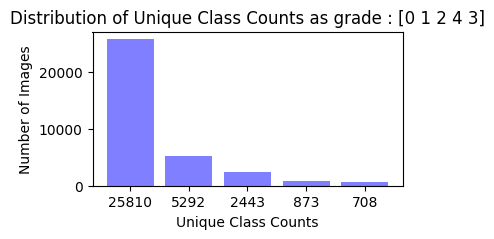

Number of images in each class:
Class 0: 25810 images
Class 2: 5292 images
Class 1: 2443 images
Class 3: 873 images
Class 4: 708 images


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


class_counts = df['level'].value_counts()

unique_counts = class_counts.unique()

plt.figure(figsize=(4, 2))
plt.bar(range(len(unique_counts)), unique_counts, color='blue', alpha=0.5)

plt.xlabel('Unique Class Counts')
plt.ylabel('Number of Images')
plt.title('Distribution of Unique Class Counts as grade : [0 1 2 4 3]')

plt.xticks(range(len(unique_counts)), unique_counts)

plt.show()

print("Number of images in each class:")
for level, count in class_counts.items():
    print(f"Class {level}: {count} images")


Class distribution after undersampling: {0: 708, 1: 708, 2: 708, 3: 708, 4: 708}
Resampled class counts: {0: 708, 1: 708, 2: 708, 3: 708, 4: 708}


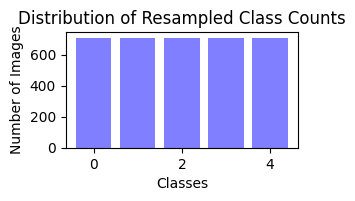

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

data = df

X = data['image']
y = data['level']

X_array = X.values.reshape(-1, 1)
y_array = y.values

class_counts = {0: 25810, 1: 2443, 2: 5292, 3: 873, 4: 708}
target_count = min(class_counts.values())

#undersampling
undersampler = RandomUnderSampler(sampling_strategy={label: target_count for label in class_counts.keys()})
X_under, y_under = undersampler.fit_resample(X_array, y_array)

print("Class distribution after undersampling:", dict(zip(*np.unique(y_under, return_counts=True))))

# Oversampling
oversampler = RandomOverSampler(sampling_strategy={label: target_count for label in np.unique(y_under)})
X_resampled, y_resampled = oversampler.fit_resample(X_under, y_under)

# New class counts after resampling
unique, counts = np.unique(y_resampled, return_counts=True)
resampled_class_counts = dict(zip(unique, counts))
print("Resampled class counts:", resampled_class_counts)

plt.figure(figsize=(3, 1.5))
plt.bar(resampled_class_counts.keys(), resampled_class_counts.values(), color='blue', alpha=0.5)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Resampled Class Counts')
plt.show()


In [ ]:
new_X = []
for i in X_resampled:
  for j in i:
    new_X.append(j)

In [ ]:
y_resampled

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
resampled_data = {'image': new_X,
        'level': y_resampled}

balanced_data = pd.DataFrame(resampled_data)


balanced_data.sample(10)

,image,level
666,27518_right,0
1346,42973_right,1
3513,10312_left,4
1864,16937_right,2
1949,23507_right,2
1568,33661_right,2
2400,2862_right,3
1235,39978_right,1
1613,4657_right,2
3368,15975_left,4


In [ ]:
print(balanced_data.value_counts().sum())
print(balanced_data['level'].unique())
print(balanced_data['level'].value_counts().unique())

3540
[0 1 2 3 4]
[708]


In [ ]:
balanced_data['image'] = balanced_data['image']+'.jpeg'
balanced_data['level'] = balanced_data['level'].astype(str)
balanced_data.head()

,image,level
0,7589_left.jpeg,0
1,30621_left.jpeg,0
2,15502_left.jpeg,0
3,8221_right.jpeg,0
4,41094_left.jpeg,0


In [ ]:
train, val = train_test_split(balanced_data, test_size=0.2, random_state=42)

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5

Number of samples in training set: 2832
Number of samples in validation set: 708
train 2832 validation 708


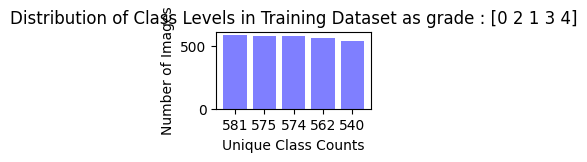

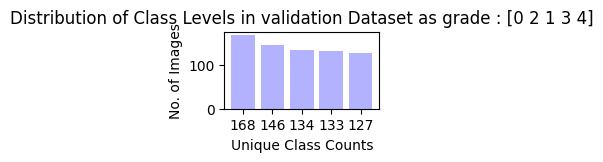

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(balanced_data, test_size=0.2, random_state=42)

print("Number of samples in training set:", len(train))
print("Number of samples in validation set:", len(val))

print('train', train.shape[0], 'validation', val.shape[0])

class_counts = train['level'].value_counts()
unique_counts = class_counts.unique()

plt.figure(figsize=(2, 1))
plt.bar(range(len(unique_counts)), unique_counts, color='blue', alpha=0.5)
plt.xlabel('Unique Class Counts')
plt.ylabel('Number of Images')
plt.title('Distribution of Class Levels in Training Dataset as grade : [0 2 1 3 4]')
plt.xticks(range(len(unique_counts)), unique_counts)
plt.show()


class_counts = val['level'].value_counts()
unique_counts = class_counts.unique()

plt.figure(figsize=(2, 1))
plt.bar(range(len(unique_counts)), unique_counts, color='blue', alpha=0.3)

plt.xlabel('Unique Class Counts')
plt.ylabel('No. of Images')
plt.title('Distribution of Class Levels in validation Dataset as grade : [0 2 1 3 4]')

plt.xticks(range(len(unique_counts)), unique_counts)

plt.show()

**Applying Modified Preprocessing**

In [ ]:
import cv2
import numpy as np

def apply_clahe(img):
    #Single channel clahe on green channel
    green_channel = img[:, :, 1]
    green_channel_8u = cv2.convertScaleAbs(green_channel)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_green_8u = clahe.apply(green_channel_8u)

    clahe_green_16u = np.array(clahe_green_8u, dtype=np.uint16)
    clahe_green_float = clahe_green_16u.astype(np.float32)

    processed_img = img.copy()
    processed_img[:, :, 1] = clahe_green_float

    return processed_img


def apply_ben_graham_kernel(image):
    # Apply the Ben Graham kernel to edge enhancement
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    enhanced_image = cv2.filter2D(image, -1, kernel)
    return enhanced_image



def clip_image(img, target_size=(224, 224)):
    #Clips the image to 90% size to remove boundary effects, and optionally applies resizing and normalization.
    #img = cv2.GaussianBlur(img, (0, 0),  10)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    center = (img.shape[1] // 2, img.shape[0] // 2)
    radius = int(300 * 0.9)
    cv2.circle(mask, center, radius, 255, -1)
    img_masked = cv2.bitwise_and(img,img, mask=mask)

    img = cv2.resize(img_masked, target_size)

    return img



def preprocess_image(image):
    processed_image = apply_clahe(image)
    processed_image = clip_image(processed_image)
    processed_image = cv2.GaussianBlur(processed_image, (3, 3), 10)
    processed_image = apply_ben_graham_kernel(processed_image)
    return processed_image



In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip = True,
    preprocessing_function=preprocess_image
)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=r'/content/drive/MyDrive/eyePACS/train',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip = True,
    preprocessing_function=preprocess_image

)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory=r'/content/drive/MyDrive/eyePACS/train',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 2832 validated image filenames belonging to 5 classes.
Found 708 validated image filenames belonging to 5 classes.


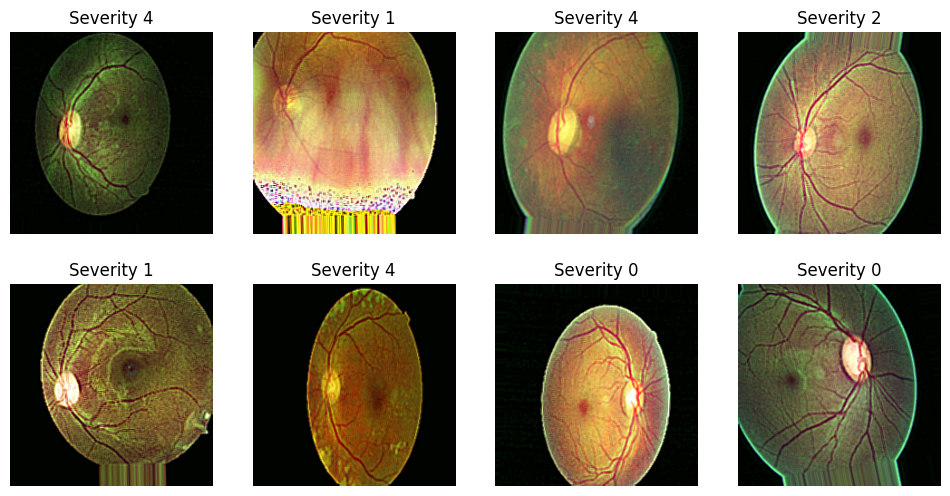

In [ ]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(2, 4, figsize = (12, 6))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x)
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

In [ ]:
import os

# Define the directory path
checkpoint_dir = '/content/drive/MyDrive/ensemble_model_2/'

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

**InceptionV3**

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

# Build model with best parameters
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in inceptionv3.layers:
    layer.trainable = False

x = inceptionv3.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu', kernel_regularizer=l2( 0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(512, activation='relu', kernel_regularizer=l2( 0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

NUM_CLASSES = 5
inceptionv3_pred = Dense(NUM_CLASSES, activation='softmax')(x)

best_model_inceptionV3 = Model(inputs=inceptionv3.input, outputs=inceptionv3_pred)


best_model_inceptionV3.compile(
    optimizer=Adam(learning_rate=0.00010093485778680839),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'inception_V3_m.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)
# Callbacks: Early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    checkpoint_callback
]

# Train the model
history_x = best_model_inceptionV3.fit(train_generator, validation_data=val_generator, epochs=100, batch_size=16, callbacks=callbacks)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 2954s 31s/step - accuracy: 0.2846 - loss: 13.2727 - val_accuracy: 0.2980 - val_loss: 12.4359 - learning_rate: 1.0093e-04
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.3332 - loss: 12.5605 - val_accuracy: 0.3079 - val_loss: 12.1657 - learning_rate: 1.0093e-04
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.3738 - loss: 12.0749 - val_accuracy: 0.3376 - val_loss: 11.7111 - learning_rate: 1.0093e-04
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.3840 - loss: 11.6602 - val_accuracy: 0.3249 - val_loss: 11.4141 - learning_rate: 1.0093e-04
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.3892 - loss: 11.2917 - val_accuracy: 0.3418 - val_loss: 11.0462 - learning_rate: 1.0093e-04
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.3772 - loss: 10.8885 - val_accuracy: 0.3376 - val_loss: 10.7062 - learning_rate: 1.0093e-04
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

# Load the saved model
inceptionV3_model = load_model('/content/drive/MyDrive/ensemble_model_2/inception_V3_m.keras')

# Set a new learning rate for the optimizer
new_learning_rate =1.0093e-04   # Set the new learning rate

# Re-compile the model with the new learning rate
optimizer = Adam(learning_rate=new_learning_rate)
inceptionV3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'inception_V3_m3.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    checkpoint_callback
]


# Continue training for more epochs with the adjusted learning rate
history = inceptionV3_model.fit(
    train_generator, validation_data=val_generator,
    epochs=40,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 996s 11s/step - accuracy: 0.4225 - loss: 2.4669 - val_accuracy: 0.4576 - val_loss: 2.3066 - learning_rate: 1.0093e-04
Epoch 2/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 688s 7s/step - accuracy: 0.4233 - loss: 2.3336 - val_accuracy: 0.4082 - val_loss: 2.2875 - learning_rate: 1.0093e-04
Epoch 3/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 741s 7s/step - accuracy: 0.4349 - loss: 2.2241 - val_accuracy: 0.4449 - val_loss: 2.1600 - learning_rate: 1.0093e-04
Epoch 4/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 682s 7s/step - accuracy: 0.4498 - loss: 2.1653 - val_accuracy: 0.4350 - val_loss: 2.1801 - learning_rate: 1.0093e-04
Epoch 5/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 690s 8s/step - accuracy: 0.4427 - loss: 2.1272 - val_accuracy: 0.4548 - val_loss: 2.1583 - learning_rate: 1.0093e-04
Epoch 6/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 686s 7s/step - accuracy: 0.4549 - loss: 2.1116 - val_accuracy: 0.4435 - val_loss: 2.1103 - learning_rate: 1.0093e-04
Epoch 7/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 729s 7s/step - accuracy: 0.4664

In [ ]:
import os

# Define the directory and file path
model_directory = '/content/drive/MyDrive/ensemble_model'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model_save_path = os.path.join(model_directory, 'inception_v3m2.keras')

# Save the model
inceptionV3_model.save(model_save_path)

# Print the path of the saved model
print("Model saved at:", model_save_path)


Model saved at: /content/drive/MyDrive/ensemble_model/inception_v3m2.keras


**Model evaluation**

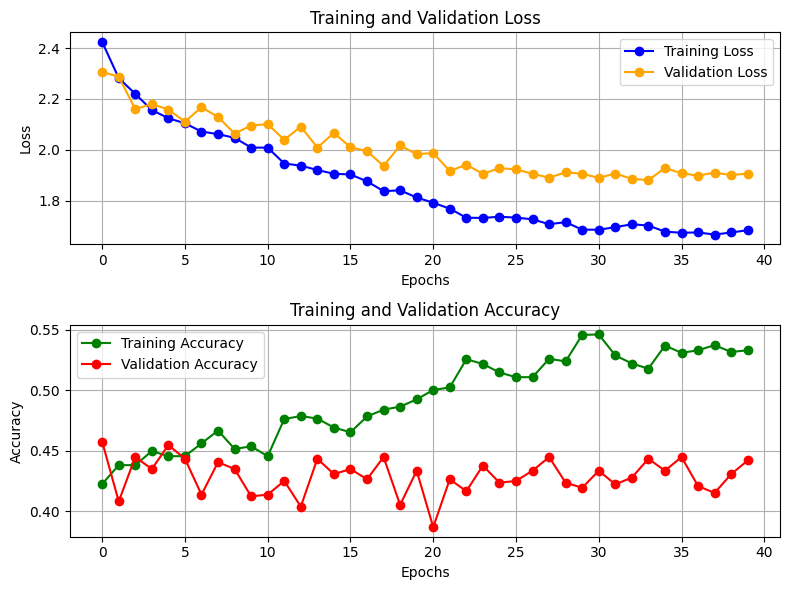

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='green', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
val_loss, val_accuracy =inceptionV3_model.evaluate(val_generator)

print("Validation Accuracy:", val_accuracy)
print("Validation loss:", val_loss)

23/23 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.4383 - loss: 1.8435
Validation Accuracy: 0.4265536665916443
Validation loss: 1.8759829998016357
